# Series temporales con Prophet: Evolución del precio de las acciones de Walmart

Este notebook está extraído de este [post](https://medium.com/future-vision/intro-to-prophet-9d5b1cbd674e).

Los modelos de series temporales permiten predecir valores futuros basándonos en valores previamente observados y aunque no son tan populares como otras técnicas, son muy útiles en muchos ámbitos, como las finanzas, la estimación de carga de servidores informáticos, el negocio inmobiliario, la gestión de infraestructuras, etc.

Hay muchas técnicas para el estudio de las series temporales ([ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), [ARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity), [regressive models](https://en.wikipedia.org/wiki/Autoregressive_model), [neural networks](https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589)), y la matemática que subyace puede ser bastante compleja y se sale del ámbito de este curso, así que vamos a tratar este tipo de análisis desde una perspectiva muy práctica y directamente operativa, para lo que utilizaremos [Prophet](https://facebook.github.io/prophet/), una herramienta desarrollada por Facebook que se liberó al público en 2017, muy fácil de utilizar y a la vez muy potente:

*Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.*

Para conocer mejor la matemática de Prophet y para una descripción detallada del modelo y los algoritmos que implementa se puede consultar este [link](https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a) o el artículo oficial de Facebook ["Forecasting at scale"](https://peerj.com/preprints/3190/). En resumen, usa un [modelo de regresión aditiva](https://en.wikipedia.org/wiki/Additive_model) para descomponer la serie temporal en varios componentes: la tendencia (*trend*), la estacionalidad (*seasonality*), los festivos (*holidays*) y el error:

$$y(t) = g(t) + s(t) + h(t) + e(t)$$

- $g(t)$ es la tendencia, que representa los cambios no periódicos que se modelizarán asumiendo una relación lineal o logística.

- $s(t)$ es la estacionalidad, que representa cambios periódicos: semanales, mensuales, anuales, etc.

- $h(t)$ es el efecto de los festivos, que pueden aparecer de manera irregular y tener una duración de 1 día o más.

- $e(t)$ es el término de error, que representa cambios *idiosincrásicos* que no se pueden acomodar al modelo. Se asume que estos errores deben tener una distribución normal.

### Tendencia

Prophet implementa dos posibles modelos de tendencia para $g(t)$.

El primero se denomina *modelo de crecimiento saturado no lineal*, y se representa como un modelo de [modelo de crecimiento logístico](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}}$$

donde:
* $C$ la capacidad (el valor máximo de la curva).
* $k$ es la constante de crecimiento (representa la "inclinación" de la curva).
* $m$ es una constante de *offset*.

Esta ecuación permite modelizar crecimientos no lineales con saturación, cuando la velocidad de crecimiento disminuye con el propio crecimiento. Un ejemplo típico puede ser el crecimiento de usuarios de una aplicación o una página web.

Los valores de $C$ y $k$ pueden variar en el tiempo, y Prophet ajusta sus valores automaticamente, localizando los puntos en los que hay cambios de tendencia o permitiendo que se indiquen manualmente, si se tiene constancia de algún factor que haya podido modificar el patrón de crecimiento (por ejemplo, que se haya rediseñado la aplicación o la página web). 

El segundo se denomina *modelo lineal por partes (piecewise)*, con una velocidad de crecimiento que permanece constante dentro de un intervalo, hasta que se produzca un cambio de tendencia.

### Estacionalidad

El componente estacional $s(t)$ modeliza los cambios periódicos, como los semanales o los anuales. Para los cambios semanales se añaden seis nuevas variables: `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, que toman el valor 0 o 1 dependiendo del día de la semana. No se añade la variable `sunday` porque es una combinación de las anteriores, teniendo un efecto adverso en el modelo. Los cambios anuales se modelizan con series de Fourier. También es posible contemplar otros tipos de estacionalidad, como la diaria o la sub-diaria.

### Festivos y eventos

El componente $h(t)$ representa días atípicos que aparecen a intervalos no regulares, como el *black friday*, la semana santa, etc. El usuario debe proporcionar una lista en la que aparecen las fechas de estos eventos.

### Error

Por último, el término de error $e(t)$ representa cualquier información que no sea contemplada por el modelo. Generalmente tiene una distribución normal, lo que indica un origen totalmente aleatorio.

### Evaluación de los modelos

En el artículo original en el que se presentó, Prophet se comparaba con otros métodos de análisis de series temporales usando el error porcentual absoluto promedio ([Mean Absolute Percentage Error, MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) para determinar la precisión de las predicciones.

![Timeseries](../img/timeseries.png)


El MAPE se define de la siguiente manera:

Si $y_{i}$ es el *valor verdadero (histórico)* y $\hat{y}_{i}$ es el *valor predicho* que genera nuestro modelo, entonces $e_{i} = y_{i} - \hat{y}_{i}$ es el *error de la predicción* y $p_{i} =\frac{\displaystyle e_{i}}{\displaystyle y_{i}}$ es el *error relativo de la predicción*.

Definimos entonces

$$MAPE = promedio\big(\left |p_{i} \right |\big)$$

MAPE se usa ampliamente como medida de la precisión de la predicción porque expresa el error como un porcentaje, por lo que se puede aplicar en cualquier ámbito. Adicionalmente se puede calcular el error absolutio medio [MAE (Mean Absolute Error)](https://en.wikipedia.org/wiki/Mean_absolute_error) para tener una visión de los errores en sus unidades absolutas. El MAE se define como

$$MAE = promedio\big(\left |e_{i}\right |\big)$$

En el artículo, los modelos con los que Prophet se comparó son bastante simples y se usan como punto de partida para construir otros modelos mas complejos:

* `naive` es un modelo simplista en el que cada valor se calcula únicamente teniendo en cuenta el valor inmediatamente anterior en el tiempo.

* `snaive` (seasonal naive) es una modificación del anterior en la que se introduce una componente estacional. Por ejemplo, para predecir el valor en un lunes se utiliza el valor del lunes anterior, etc.

* `mean` usa el valor promediado de los datos como predicción futura.

* `arima` hace referencia al procedimiento *Autoregressive Integrated Moving Average*, más detalles en la [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).

* `ets` significa alisado exponencial (*Exponential Smoothing*), más detalles en la [Wikipedia](https://en.wikipedia.org/wiki/Exponential_smoothing).

Vamos a realizar un ejercicio básico en el que utilizaremos Prophet para modelar el precio de las acciones de la compañía Walmart en la bolsa de Nueva York. Comenzamos como siempre cargando las librerías que necesitaremos, pero primero hay que asegurarse de que Prophet está correctamente instalado en nuestro espacio de trabajo. Hay que tener cuidado, porque existen incompatibilidades entre algunos paquetes, hay que asegurarse de que tenemos instalados exactamente las versiones que se indican:

In [1]:
# !pip install fbprophet==0.5
# !pip install holidays==0.9.12
# !pip install pandas==0.25.3

In [2]:
import warnings
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import time

# Disable warnings
warnings.filterwarnings('ignore')
# High resolution
%config InlineBackend.figure_format = 'retina'

Descargamos el dataset desde el repo del curso y lo cargamos en el espacio de trabajo de Colab:

In [3]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
!wget -P ./../data/ https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/Datasets/Tabular/WMT.csv

In [4]:
wmt = pd.read_csv('./../data/WMT.csv')

Los datos se han extraído de Yahoo Finance ([link](https://finance.yahoo.com/quote/WMT/history?period1=83574000&period2=1562137200&interval=1d&filter=history&frequency=1d)), son datos reales de la evolución del precio en dólares de las acciones de Walmart Inc. (WMT) en la bolsa de Nueva York (NYSE) entre el 25 de agosto de 1972 y el 2 de julio de 2019. Vamos a hacer un breve EDA:

In [5]:
wmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12337 entries, 0 to 12336
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12337 non-null  object 
 1   Open       12337 non-null  float64
 2   High       12337 non-null  float64
 3   Low        12337 non-null  float64
 4   Close      12337 non-null  float64
 5   Adj Close  12337 non-null  float64
 6   Volume     12337 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 674.8+ KB


In [6]:
wmt.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12337.000000,12337.000000,12337.000000,12337.000000,12337.000000,1.233700e+04
mean,34.149572,34.471101,33.830777,34.155502,27.652820,7.530037e+06
std,35.444814,35.744425,35.161358,35.451844,32.513613,6.260042e+06
min,0.015625,0.015625,0.014404,0.015625,0.008925,0.000000e+00
25%,1.359375,1.371094,1.343750,1.359375,0.844786,3.848600e+06
50%,15.375000,15.500000,15.218750,15.406250,9.997795,6.292900e+06
75%,55.630001,56.240002,55.049999,55.689999,40.614838,9.507400e+06
max,153.600006,153.660004,151.660004,152.789993,150.453888,1.318336e+08


In [7]:
wmt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.036455,972800
1,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.036040,1945600
2,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.036040,409600
3,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.035485,870400
4,1972-09-01,0.062744,0.062988,0.062744,0.062988,0.035762,256000


Vemos que en total tenemos precios de 11,815 días de sesión bursátil, la fecha se encuentra en la variable *Date* y el precio de la acción se encuentra en la variable *Adj Close*. Estas son las dos variables que usaremos con Prophet, las demás no las utilizaremos. Debemos formatear los datos para poder usarlos, cambiando el nombre de las columnas y convirtiendo las fechas de texto a *datetime*:

In [8]:
# forge new dataframe with date and adjusted closing price
wmt = wmt[['Date','Adj Close']]
# adjust column names for prophet compliance
wmt.columns = ['ds','y']
# convert dates from string to datetime
wmt.ds = pd.to_datetime(wmt.ds)

# display adjustments
wmt.tail()

,ds,y
12332,2021-07-23,141.907791
12333,2021-07-26,142.107071
12334,2021-07-27,142.117020
12335,2021-07-28,141.539154
12336,2021-07-29,141.718491


Vamos a echar un vistazo a los datos representando gráficamente cómo varía el precio de las acciones con el tiempo:

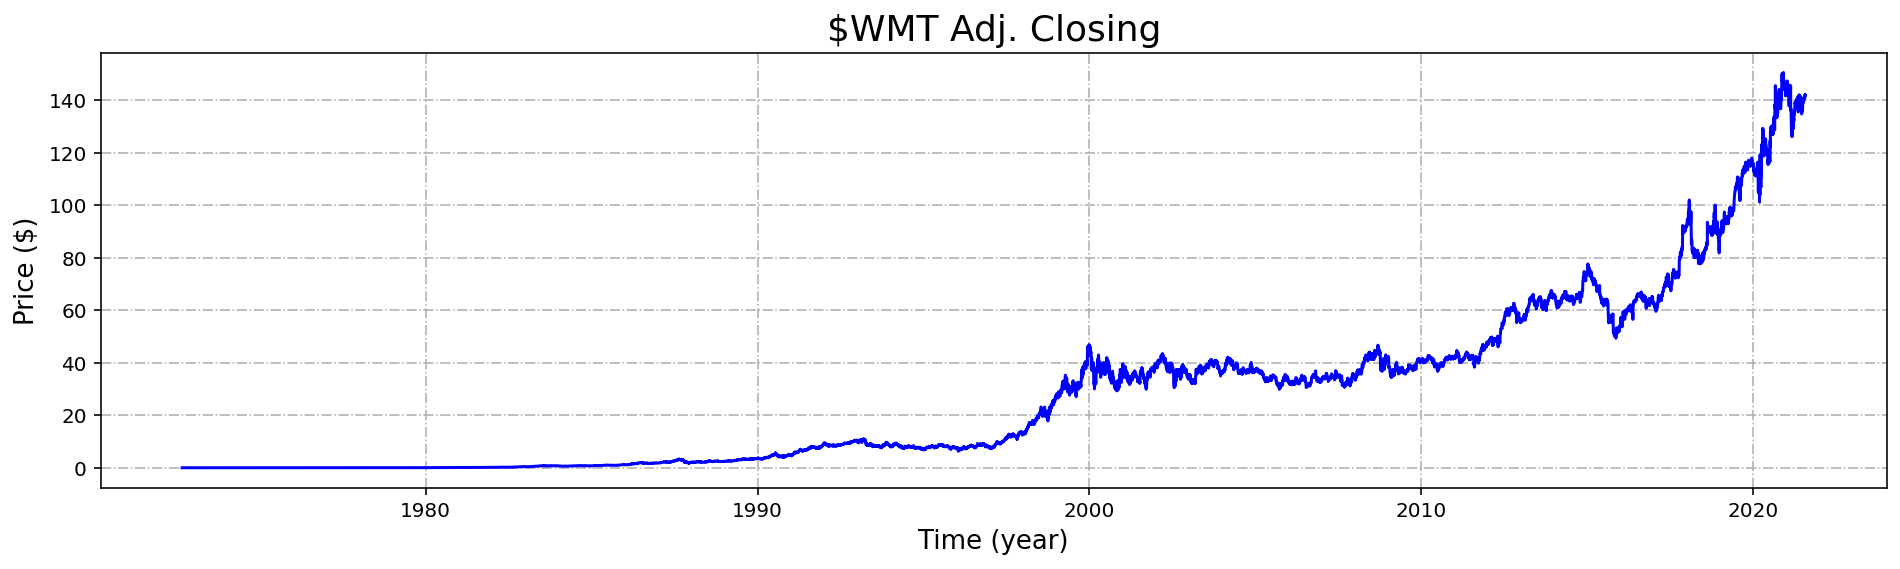

In [9]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(wmt.ds, wmt.y, 'b')

# set title & labels
plt.title('$WMT Adj. Closing', fontsize=18)
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

Vemos que en general el precio de las acciones aumenta constantemente, aunque a velocidad variable, unas veces muy rápido y otras más lento. Puntualmente se puede producir algún descenso pronunciado. Vamos ahora a crear un modelo de Prophet que intente reproducir este comportamiento. Comenzamos definiendo el modelo, luego lo ajustamos a nuestros datos con **fit**, y por último realizamos una predicción. Como entrada para el método **fit** necesitamos un DataFrame con dos columnas:

- **ds** (datestamp) debe ser de tipo **date** o **datetime**.
- **y** es el valor (numérico) a predecir.

Nuestros datos ya cumplen estos requisitos, así que procedemos a crear el modelo, entrenarlo y predecir con él el valor de las acciones en los próximos 5 años:

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


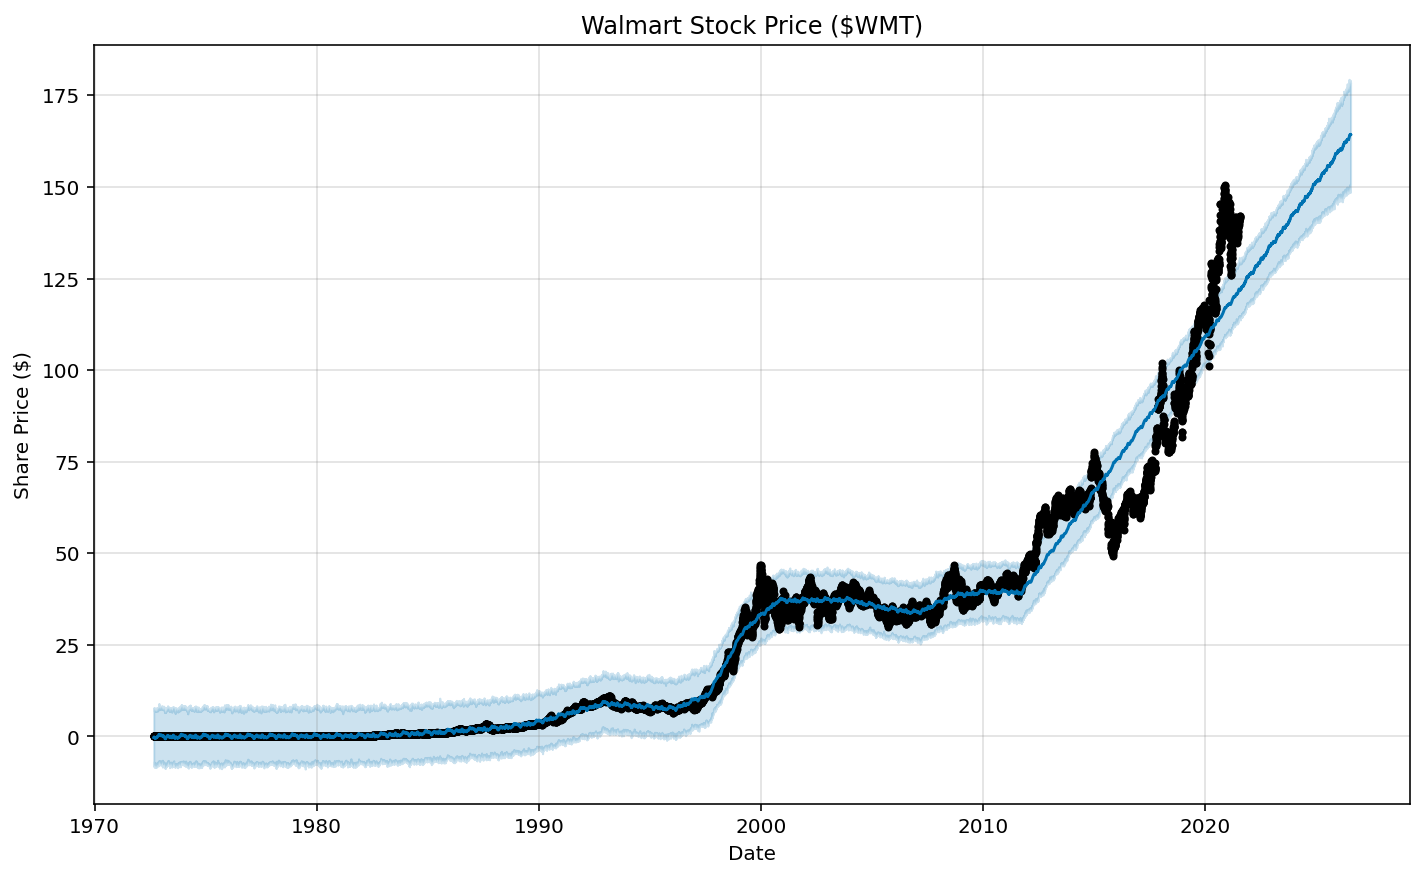

43.31937551498413

In [10]:
myTime = time.time()

# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False,)

# fit $wmt data to model
prophet.fit(wmt)

# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods=365*5, freq='D')

# forecast future df with model
forecast = prophet.predict(build_forecast)

# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Walmart Stock Price ($WMT)')
plt.show()

time.time() - myTime

En esta gráfica los puntos negros indican los verdaderos valores de los precios de las acciones, la línea azul son los precios predichos por Prophet, y la zona azul claro es el intervalo de confianza de esas predicciones. Estos intervalos no enmarcan exactamente los precios verdaderos, solo indican la incertidumbre de las predicciones y si existe *overfitting*. Ahora vamos a desglosar los distintos componentes del modelo:

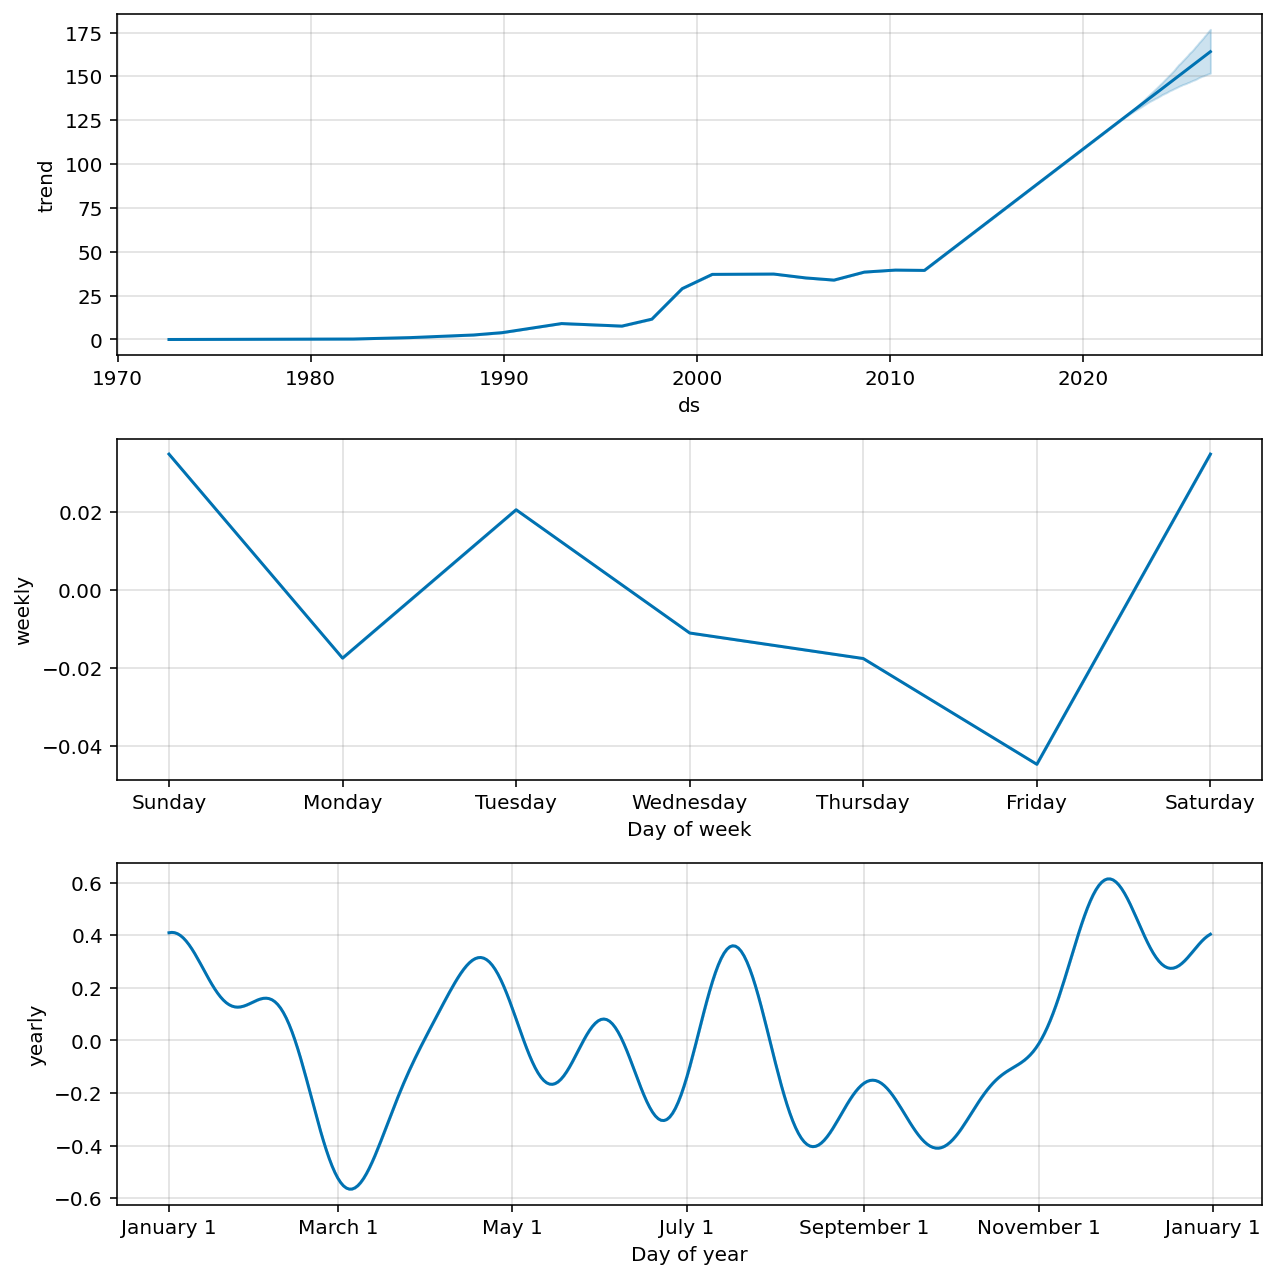

In [11]:
# tell us more about the forecast
components = prophet.plot_components(forecast)

Vemos que en general los precios de las acciones suelen alcanzar un valor máximo los fines de semana, que caen de precio en marzo, y que su valor aumenta sistemáticamente con el tiempo, aunque a un ritmo variable.

Podemos comparar ahora las predicciones que hemos hecho con los valores actuales en la bolsa de Nueva York ([link](https://finance.yahoo.com/quote/WMT/history?period1=83808000&period2=1635206400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)):

In [12]:
# narrow selection to dates past initial dataframe
future_preds = forecast.loc[forecast.ds>'2021-10-15']
# select date, prediction, lower and upper limits 
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
# display some predictions
future_preds.head(10)

,ds,yhat,yhat_lower,yhat_upper
12415,2021-10-16,123.700961,115.908174,130.819213
12416,2021-10-17,123.735108,116.279277,131.162184
12417,2021-10-18,123.715867,115.869655,130.978262
12418,2021-10-19,123.785920,116.489158,131.379369
12419,2021-10-20,123.785463,116.412791,130.465646
12420,2021-10-21,123.809311,116.326113,131.320925
12421,2021-10-22,123.812069,116.026729,131.433137
12422,2021-10-23,123.921129,116.589968,131.661075
12423,2021-10-24,123.950665,116.840340,131.188865
12424,2021-10-25,123.928163,116.538330,131.877955


Vemos que nuestras predicciones están infravaloradas, el precio actual es significativamente mayor (132 dólares predichos vs. 150 dólares reales aproximadamente). Las predicciones de nuestro modelo, aunque no están mal, no son tan precisas como nos hubiese gustado. Para hacer una estimación de la precisión de nuestras predicciones podemos usar un procedimiento de validación cruzada incorporado en Prophet, en el que se hacen predicciones a cierto horizonte (por ejemplo 365 días) cada cierto intervalo (por ejemplo 180 días) trascurrido cierto periodo de tiempo (por ejemplo 730 días). Vamos a aplicar este procedimiento sobre 30 años de datos validando predicciones s 365 días cada 180 días:

In [13]:
myTime = time.time()

# OJO! POR ACORTAR EN LUGAR DE 30 AÑOS VAMOS A USAR 45, 
# EN LUGAR DE 10950 DÍAS PONDREMOS 16425
# SI NO LO HACÉIS, TARDARÁ MÁS DE 10 MINUTOS EN ACABAR
wmt_cv = cross_validation(prophet, initial='16425 days', period='180 days', horizon = '365 days')

time.time() - myTime

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-02-10 00:00:00 and 2020-07-29 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

139.448144197464

Echamos un vistazo al resultado de la validación y determinamos la precisión:

In [14]:
# example output 
wmt_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-02-12,75.717323,71.355345,80.041299,92.650772,2018-02-10
1,2018-02-13,75.707012,71.196388,79.879055,93.981674,2018-02-10
2,2018-02-14,75.680085,71.617376,79.936262,94.651764,2018-02-10
3,2018-02-15,75.647746,71.458618,79.832232,96.075729,2018-02-10
4,2018-02-16,75.621464,71.352641,79.828642,97.518318,2018-02-10


In [15]:
# how's the preformance  
wmt_pm = performance_metrics(wmt_cv)

In [16]:
# final accuracy
wmt_pm.tail(3)

,horizon,mse,rmse,mae,mape,mdape,coverage
326,363 days,816.373616,28.572253,26.981082,0.218641,0.219091,0.0
327,364 days,820.193965,28.639029,27.085070,0.219340,0.219354,0.0
328,365 days,820.387906,28.642414,27.124762,0.219675,0.219354,0.0


Se recomienda usar la métrica MAPE (*Mean Absolute Percentage Error*, error porcentual absoluto medio) para determinar el error, así que la vamos a representar gráficamente:

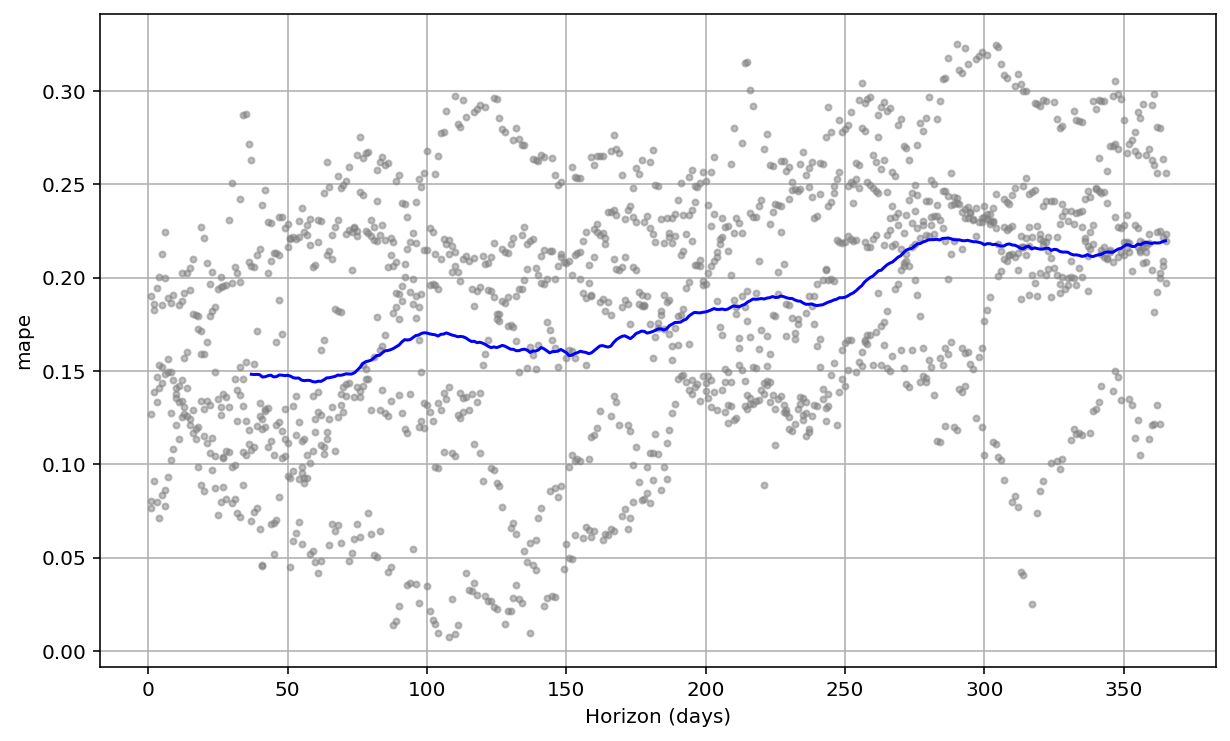

In [17]:
# visualize mape across horizon (continued sort)
fig = plot_cross_validation_metric(wmt_cv, metric='mape')

Vemos que se estima un error de entre el 15% y el 23% en las predicciones, lo que cuadra con nuestras comprobaciones anteriores.